In [1]:
import pandas as pd
import json
import os
from rank_bm25 import BM25Okapi
from matplotlib import pyplot as plt
import numpy as np
import utils

In [16]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

sw_nltk = stopwords.words('english')
porter = PorterStemmer()

def preprocess(sentence):
    sentence = sentence.lower()
    return sentence.split()
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return [porter.stem(word) for word in sentence.split() if word not in sw_nltk]

In [17]:
import importlib
importlib.reload(utils)

tweets, test_tweets = utils.get_tweets()
test_tweets = test_tweets[1:]
train_conns, dev_conns, test_conns = utils.get_qrels()
claims = utils.get_claims()

In [18]:
len(claims)

13825

In [19]:
# claims.reset_index()
claims.iloc[train_conns.negative_claim_idx].vclaim.to_numpy().shape

(999,)

In [20]:
train_conns.head()

,tweet_id,tweet_num,claim_id,claim_num,negative_claim_idx
0,tweet-sno-0,0,vclaim-sno-hero-wombats-australia-fires,1,1448
1,tweet-sno-1,0,vclaim-sno-ilhan-omar-treason-advice-iran,1,13330
2,tweet-sno-2,0,vclaim-sno-us-army-sending-texts-on-draft,1,10686
3,tweet-sno-3,0,vclaim-sno-us-army-sending-texts-on-draft,1,13142
4,tweet-sno-4,0,vclaim-sno-video-of-drone-strike-soleimani,1,10071


In [21]:
# corpus = claims.vclaim.to_list()
corpus = claims[["title", "subtitle", "vclaim"]].apply(lambda x: x[0]+' '+x[1]+' '+x[2], axis=1).to_list()
tokenized_corpus = [preprocess(doc) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [22]:
def get_bm25_rankings(connections, claims, tweets):
    run_tweets = tweets.join(connections.set_index("tweet_id"), on="id", how="inner")
    run_tweets = run_tweets.join(claims.set_index("vclaim_id"), on="claim_id", how="inner")
    run_tweets = run_tweets[["tweet", "vclaim"]]
    claim_idx = [claims.vclaim.to_list().index(t_claim) for t_claim in run_tweets.vclaim.to_list()]
    
    queries = run_tweets.tweet.to_list()
    tokenized_queries = [preprocess(query) for query in queries]
    doc_scores = [bm25.get_scores(query) for query in tokenized_queries]
    doc_ranks = [score.argsort()[::-1] for score in doc_scores]
    label_ranks = [list(doc_rank).index(idx) for idx, doc_rank in zip(claim_idx, doc_ranks)]
    
    return doc_scores, doc_ranks, claim_idx, label_ranks

In [23]:
doc_scores, doc_ranks, claim_idx, label_ranks = get_bm25_rankings(train_conns, claims, tweets)

In [24]:
cumulatives = []
N = 100
for i in range(N):
    cumulatives.append((np.array(label_ranks) <= i).sum() / len(label_ranks))

Text(0.5, 1.0, 'Recall vs BM25 ranking on training partition')

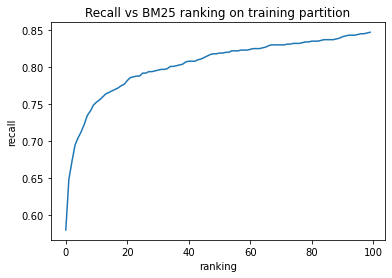

In [25]:
plt.plot(range(N), cumulatives)
plt.xlabel("ranking")
plt.ylabel("recall")
plt.title("Recall vs BM25 ranking on training partition")

In [26]:
def avg_prec(gold, rankings, n):
    is_rel = (np.array(rankings)[:n] == gold).astype(float)
    return (is_rel/np.arange(1,n+1)).sum()

def mean_avg_prec(golds, rankings, n):
    avg_precs = [avg_prec(gold, rlist, n) for gold, rlist in zip(golds, rankings)]
    return np.array(avg_precs).mean()

In [27]:
doc_scores, doc_ranks, claim_idx, label_ranks = get_bm25_rankings(train_conns, claims, tweets)

map_results = {}
for ptn in ["train", "dev", "test"]:
    if ptn == "train":
        doc_scores, doc_ranks, claim_idx, label_ranks = get_bm25_rankings(train_conns, claims, tweets)
    elif ptn == "dev":
        doc_scores, doc_ranks, claim_idx, label_ranks = get_bm25_rankings(dev_conns, claims, tweets)
    elif ptn == "test":
        doc_scores, doc_ranks, claim_idx, label_ranks = get_bm25_rankings(test_conns, claims, test_tweets)
    
    map_results[ptn] = []
    for n in [1,5,10,20]:
        map_results[ptn].append(mean_avg_prec(claim_idx, doc_ranks, n))

In [28]:
map_results

{'train': [0.5805805805805806,
  0.6301301301301301,
  0.6358644358644359,
  0.6378184190447692],
 'dev': [0.655, 0.70475, 0.7085892857142858, 0.7112121371275784],
 'test': [0.6336633663366337,
  0.6882013201320133,
  0.6961280056577086,
  0.6971105052234546]}

In [ ]:
top_negative_ranks = [doc_rank[~np.isin(doc_rank, claim_idx)][0] for doc_rank in doc_ranks]

In [ ]:
#with open("train_negative_ranks.npy", "w") as f:
np.save("train_negative_ranks.npy", top_negative_ranks)

In [ ]:
np.load("train_negative_ranks.npy").shape

In [74]:
train_conns.head()

,tweet_id,tweet_num,claim_id,claim_num,negative_claim_idx
0,tweet-sno-0,0,vclaim-sno-hero-wombats-australia-fires,1,1448
1,tweet-sno-1,0,vclaim-sno-ilhan-omar-treason-advice-iran,1,13330
2,tweet-sno-2,0,vclaim-sno-us-army-sending-texts-on-draft,1,10686
3,tweet-sno-3,0,vclaim-sno-us-army-sending-texts-on-draft,1,13142
4,tweet-sno-4,0,vclaim-sno-video-of-drone-strike-soleimani,1,10071


In [73]:
np.load("train_negative_ranks.npy").shape
train_conns["negative_claim_idx"] = top_negative_ranks